In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
# Movies dataset
movies = pd.read_csv("Netflix_Dataset_Movie.csv")
print(movies.head())

# Ratings dataset
ratings = pd.read_csv("Netflix_Dataset_Rating.csv")
print(ratings.head())


   Movie_ID  Year                          Name
0         1  2003               Dinosaur Planet
1         2  2004    Isle of Man TT 2004 Review
2         3  1997                     Character
3         4  1994  Paula Abdul's Get Up & Dance
4         5  2004      The Rise and Fall of ECW
   User_ID  Rating  Movie_ID
0   712664       5         3
1  1331154       4         3
2  2632461       3         3
3    44937       5         3
4   656399       4         3


In [ ]:
print(movies.info())
print(ratings.info())
print(movies.isnull().sum())
print(ratings.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie_ID  17770 non-null  int64 
 1   Year      17770 non-null  int64 
 2   Name      17770 non-null  object
dtypes: int64(2), object(1)
memory usage: 416.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17337458 entries, 0 to 17337457
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   User_ID   int64
 1   Rating    int64
 2   Movie_ID  int64
dtypes: int64(3)
memory usage: 396.8 MB
None
Movie_ID    0
Year        0
Name        0
dtype: int64
User_ID     0
Rating      0
Movie_ID    0
dtype: int64


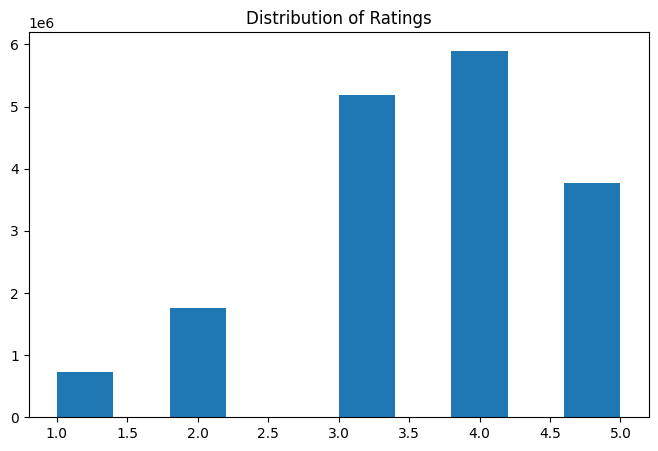

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(ratings['Rating'])
plt.title("Distribution of Ratings")
plt.show()

In [ ]:
top_rated_movies = ratings.groupby('Movie_ID')['Rating'].count().sort_values(ascending=False).head(10)
top_rated_movies = top_rated_movies.reset_index()
top_rated_movies = top_rated_movies.merge(movies, left_on='Movie_ID', right_on='Movie_ID')
print(top_rated_movies[['Name', 'Rating']])


                                                Name  Rating
0  Pirates of the Caribbean: The Curse of the Bla...  117075
1      Lord of the Rings: The Fellowship of the Ring  102721
2                                    The Sixth Sense  102376
3                                    American Beauty  101450
4                                     Bruce Almighty   98545
5                           The Silence of the Lambs   95053
6                          Finding Nemo (Widescreen)   94235
7                                    The Italian Job   93886
8                                            Shrek 2   92893
9                                         Braveheart   91502


In [ ]:
# Encode movie name
le_name = LabelEncoder()
movies['name_encoded'] = le_name.fit_transform(movies['Name'].astype(str))

# Merge ratings with movies for regression
data = ratings.merge(movies[['Movie_ID', 'name_encoded']], left_on='Movie_ID', right_on='Movie_ID')
X = data[['User_ID', 'name_encoded']]
y = data['Rating']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=10, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Linear Regression": LinearRegression()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "R2": r2}
    print(f"{name} --> RMSE: {rmse:.3f}, R2: {r2:.3f}")


In [ ]:
results_df = pd.DataFrame(results).T
print(results_df)
results_df.plot(kind='bar', figsize=(10,6))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.show()

In [ ]:
# Create user-movie matrix
user_movie_matrix = ratings.pivot(index='Using_ID', columns='Movie_Id', values='Rating').fillna(0)

# Movie similarity matrix
movie_similarity = cosine_similarity(user_movie_matrix.T)
movie_similarity_df = pd.DataFrame(movie_similarity, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)

# Function to recommend movies based on a movie
def recommend_movies(movie_id, num_recommendations=5):
    similar_scores = movie_similarity_df[movie_id].sort_values(ascending=False)
    similar_movies = similar_scores.index[1:num_recommendations+1]
    recommended = movies[movies['movie_id'].isin(similar_movies)][['movie_id', 'name', 'year']]
    return recommended


In [ ]:
recommend_movies(1, num_recommendations=5)


In [ ]:
# Use best model (Random Forest)
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X, y)

data['Predicted_Rating'] = best_model.predict(X)

# Top recommended movies
top_movies = data.groupby('Movie_Id')['Predicted_Rating'].mean().sort_values(ascending=False).head(10)
top_movies = top_movies.reset_index()
top_movies = top_movies.merge(movies, left_on='Movie_Id', right_on='movie_id')
print(top_movies[['name', 'year', 'Predicted_Rating']])
